# Test Non-stack Version of PPO

### Imports

In [1]:
import numpy as np
from pettingzoo.atari import boxing_v2
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import pad_observations_v0, pad_action_space_v0, resize_v1, normalize_obs_v0, frame_skip_v0, dtype_v0
from pettingzoo.utils import aec_to_parallel
import matplotlib.pyplot as plt
from collections import defaultdict

### RolloutBuffer

In [2]:
class RolloutBuffer:
    """
    Buffer to store rollout data for PPO.
    """
    def __init__(self):
        self.observations = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.returns = []
        self.advantages = []

    def store(self, obs, action, log_prob, reward, done):
        if obs.shape[-1] == 3:  # If observation has RGB channels
            obs = obs.mean(axis=-1)  # Convert to grayscale
        self.observations.append(obs)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)


    def compute_returns_and_advantages(self, policy, gamma, gae_lambda):
        """
        Computes returns and advantages using Generalized Advantage Estimation (GAE).

        Parameters:
        policy (PPOAgent): The policy network.
        gamma (float): Discount factor for rewards.
        gae_lambda (float): Lambda parameter for GAE.
        """
        if not self.observations:  # Guard clause
            print("Warning: Buffer is empty. Skipping returns and advantages computation.")
            self.returns = []
            self.advantages = []
            return
        
        values = [
            policy.forward_value(
                torch.tensor(
                    obs[np.newaxis, np.newaxis, :, :],  # Add batch and channel dimensions (1, 1, H, W)
                    dtype=torch.float32
                ) / 255.0  # Normalize
            ).item()
            for obs in self.observations
        ]


        next_value = 0 if self.dones[-1] else values[-1]

        # GAE computation
        returns = []
        advantages = []
        gae = 0
        for step in reversed(range(len(self.rewards))):
            delta = self.rewards[step] + gamma * next_value * (1 - self.dones[step]) - values[step]
            gae = delta + gamma * gae_lambda * (1 - self.dones[step]) * gae
            advantages.insert(0, gae)
            next_value = values[step]
            returns.insert(0, gae + values[step])

        self.returns = returns
        self.advantages = advantages


    def clear(self):
        """
        Clears the buffer.
        """
        self.observations = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.returns = []
        self.advantages = []


### PPO Agent(Networks)

In [9]:
class PPOAgent(nn.Module):
    def __init__(self, obs_shape, action_space):
        super(PPOAgent, self).__init__()
        
        # Convolutional layers adapted for single-channel input
        self.conv_layers = nn.Sequential(
            nn.Conv2d(obs_shape[0], 32, kernel_size=8, stride=4),  # obs_shape[0] is the channel size
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        
        # Dynamically calculate the feature map size
        feature_map_size = self.calculate_feature_map_size(obs_shape)
        
        # Policy network
        self.policy_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_map_size, 256),
            nn.ReLU(),
            nn.Linear(256, action_space.n),
        )
        
        # Value network
        self.value_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_map_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward_policy(self, x):
        """
        Forward pass of the policy network.
        Converts the observation to a probability distribution over actions.
        """
        x = self.conv_layers(x)
        return torch.softmax(self.policy_net(x), dim=-1)

    def forward_value(self, x):
        """
        Forward pass of the value network.
        Converts the observation to an estimated value.
        """
        x = self.conv_layers(x)
        return self.value_net(x)

    def forward(self, x):
        """
        Default forward method for compatibility in opponent policy.
        Delegates to forward_policy to output action probabilities.
        """
        return self.forward_policy(x)

    def calculate_feature_map_size(self, input_shape):
        """
        Calculates the feature map size after the convolutional layers.
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)  # Batch size of 1
            output = self.conv_layers(dummy_input)
            print("Shape after conv layers:", output.size())  # Debugging output shape
        return int(np.prod(output.size()[1:]))  # Flatten the output shape


### PPO Algorithm

In [10]:

class PPO:
    """
    Proximal Policy Optimization (PPO) implementation.
    """
    def __init__(self, obs_shape, action_space, lr=3e-4, gamma=0.8, epsilon=0.2, gae_lambda=0.95):
        self.policy = PPOAgent(obs_shape, action_space)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.gae_lambda = gae_lambda

    def update(self, buffer):
        """
        Updates the policy and value networks using PPO loss.

        Parameters:
        buffer (RolloutBuffer): The buffer containing rollout data.
        """
        policy_losses = []
        value_losses = []
        total_losses = []
        
        obs_array = np.array(buffer.observations, dtype=np.float32)  # Combine into a single numpy array
        
        """
        None Skipping version
        """
        if len(obs_array.shape) == 3:  # Handle grayscale observations (Batch, H, W)
            obs = torch.tensor(obs_array, dtype=torch.float32).unsqueeze(1) / 255.0  # Add channel dim (Batch, 1, H, W)
        else:  # If stacking was used and there are 4D observations
            obs = torch.tensor(obs_array, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (Batch, Channels, H, W)
        # print(f"Observation Shape in Update: {obs.shape}")  # Debug shape
        """
        Skipping version
        """
        # if len(obs_array.shape) == 3:  # Single-frame observations
        #     obs = torch.tensor(obs_array, dtype=torch.float32).unsqueeze(1) / 255.0  # Add channel dim
        # elif len(obs_array.shape) == 4:  # Stacked observations
        #     obs = torch.tensor(obs_array, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (Batch, Channels, H, W)
        # else:
        #     raise ValueError(f"Unexpected observation shape after skip: {obs_array.shape}")

        # print(f"Observation Shape in Update: {obs.shape}")
        
        actions = torch.tensor(buffer.actions, dtype=torch.int64)
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32)
        returns = torch.tensor(buffer.returns, dtype=torch.float32)
        advantages = torch.tensor(buffer.advantages, dtype=torch.float32)

        for _ in range(10):  # Number of PPO epochs
            # Get new log probabilities and values
            new_probs = self.policy.forward_policy(obs).gather(1, actions.unsqueeze(-1)).squeeze(-1)
            new_log_probs = torch.log(new_probs + 1e-8)
            values = self.policy.forward_value(obs).squeeze(-1)
            # print(f"Values Shape in Update: {values.shape}")

            # Compute the ratio
            ratio = torch.exp(new_log_probs - old_log_probs)

            # Compute the clipped surrogate objective
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss
            value_loss = nn.MSELoss()(values, returns)

            # Total loss
            loss = policy_loss + 0.5 * value_loss

            policy_losses.append(policy_loss.item())
            value_losses.append(value_loss.item())
            total_losses.append(loss.item())
            
            # Gradient update
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        print(f"Policy Loss: {np.mean(policy_losses)}, Value Loss: {np.mean(value_losses)}, Total Loss: {np.mean(total_losses)}")

        return policy_losses, value_losses, total_losses

    def save_policy_network(self, save_path):
        torch.save(self.policy.policy_net.state_dict(), save_path)
        print(f"Policy network saved to {save_path}")

    def save_value_network(self, save_path):
        torch.save(self.policy.value_net.state_dict(), save_path)
        print(f"Value network saved to {save_path}")
        
    def load_policy_network(self, load_path):
        loaded_state_dict = torch.load(load_path)
        # Filter keys to match `policy_net`
        filtered_state_dict = {k.replace("policy_net.", ""): v for k, v in loaded_state_dict.items() if "policy_net." in k}
        self.policy.policy_net.load_state_dict(filtered_state_dict)
        print(f"Policy network loaded from {load_path}")

    def load_value_network(self, load_path):
        loaded_state_dict = torch.load(load_path)
        # Filter keys to match `value_net`
        filtered_state_dict = {k.replace("value_net.", ""): v for k, v in loaded_state_dict.items() if "value_net." in k}
        self.policy.value_net.load_state_dict(filtered_state_dict)
        print(f"Value network loaded from {load_path}")



In [11]:
import os
save_dir = "ppo_trained_models_Dec_11"
os.makedirs(save_dir, exist_ok=True)

# File paths for saving
policy_model_path = os.path.join(save_dir, "ppo_policy_model.pth")
value_model_path = os.path.join(save_dir, "ppo_value_model.pth")

### Training

In [12]:
# # Step 1: Set up the environment
# env = boxing_v2.env(render_mode="rgb_array")
# env.reset(seed=42)
# env = pad_observations_v0(env)
# env = pad_action_space_v0(env)
# env = resize_v1(env, 84, 84)  # Resize frames to 84x84
# env = dtype_v0(env, dtype="float32")  # Convert observations to float32
# env = normalize_obs_v0(env, env_min=0, env_max=1)  # Normalize pixel values

# parallel_env = aec_to_parallel(env)  # Convert to parallel format

# # Step 2: Initialize PPO and RolloutBuffer
# obs_shape = (1, 84, 84)  # Single frame (no stacking)
# action_space = env.action_space("first_0")  # Example action space for an agent
# ppo = PPO(obs_shape, action_space)

# # Load pre-trained models
# # ppo.load_value_network(value_model_path)  # load value network
# # ppo.load_policy_network(policy_model_path) # load policy network

# # Initialize the buffer
# buffer = RolloutBuffer()

# # Step 3: Training Loop
# num_episodes = 1
# max_steps_per_episode = 5000  # Maximum steps to prevent infinite loops
# # Initialize reward tracking
# cumulative_rewards = []

# for episode in range(num_episodes):
#     # Reset the environment
#     observations = parallel_env.reset()

#     # Extract nested observations (first element of the tuple)
#     if isinstance(observations, tuple) and len(observations) > 0:
#         agent_observations = observations[0]
#     else:
#         raise ValueError(f"Unexpected observation structure: {type(observations)}")

#     # Initialize done flags for each agent
#     done = {agent: False for agent in agent_observations.keys()}
#     step = 0
#     episode_reward = defaultdict(int)  # Track total reward for the episode

#     while not all(done.values()) and step < max_steps_per_episode:
#         actions = {}
#         log_probs = {}

#         # Process observations for each agent
#         for agent, obs in agent_observations.items():
#             # Convert observations to grayscale if needed
#             if obs.shape[-1] == 3:  # If RGB format
#                 obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels

#             # Prepare tensor
#             obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

#             # Get action probabilities
#             action_probs = ppo.policy.forward_policy(obs_tensor)
#             action = torch.multinomial(action_probs, 1).item()  # Sample action
#             log_probs[agent] = torch.log(action_probs.squeeze(0)[action])  # Log probability
#             actions[agent] = action  # Store action

#         # Step the environment
#         step_output = parallel_env.step(actions)

#         if len(step_output) == 5:  # Handle truncations
#             next_observations, rewards, dones, truncations, infos = step_output
#             dones = {agent: dones[agent] or truncations[agent] for agent in dones}
#             # print(f"observations: {next_observations}")
#         else:
#             next_observations, rewards, dones, infos = step_output

#         # Extract nested observations for next step
#         if isinstance(next_observations, dict):
#             agent_observations = next_observations  # Observations are already in dictionary format
#         else:
#             raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")


#         for agent, reward in rewards.items():
#             # if reward != 0:
#             #     print(f"Agent: {agent}, Reward: {reward}")
#             episode_reward[agent] += reward
        
#         # Store data in the buffer for each agent
#         for agent, obs in agent_observations.items():
#             # print(f"Agent: {agent}, Reward: {rewards[agent]}")
#             buffer.store(obs, actions[agent], log_probs[agent].item(), rewards[agent], dones[agent])

#         # Update done flags
#         done = dones
#         step += 1

#     # Append episode reward
#     cumulative_rewards.append(episode_reward)

#     # Compute Returns and Advantages
#     print(f"Episode {episode + 1}: Episode Reward = {episode_reward}")
#     buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

#     # Update PPO
#     print(f"Episode {episode + 1}: Updating PPO model...")
#     policy_losses, value_losses, total_losses = ppo.update(buffer)

#     # Clear buffer for the next episode
#     buffer.clear()

#     # Log progress
#     print(f"Episode {episode + 1}/{num_episodes} completed.")



Shape after conv layers: torch.Size([1, 64, 9, 9])
Episode 1: Episode Reward = defaultdict(<class 'int'>, {'first_0': 3, 'second_0': -3})
Episode 1: Updating PPO model...
Policy Loss: 0.048528384417295456, Value Loss: 0.0012731621565762908, Total Loss: 0.0491649653762579
Episode 1/10 completed.
Episode 2: Episode Reward = defaultdict(<class 'int'>, {'first_0': 2, 'second_0': -2})
Episode 2: Updating PPO model...
Policy Loss: 0.0092589664272964, Value Loss: 0.0007445084862411022, Total Loss: 0.009631220623850823
Shape after conv layers: torch.Size([1, 64, 9, 9])
Checkpoint: Saved policy for self-play after Episode 2
Episode 2/10 completed.
Episode 3: Episode Reward = defaultdict(<class 'int'>, {'first_0': 8, 'second_0': -8})
Episode 3: Updating PPO model...
Policy Loss: 0.008430836070328952, Value Loss: 0.004574452387169003, Total Loss: 0.010718062240630388
Episode 3/10 completed.
Episode 4: Episode Reward = defaultdict(<class 'int'>, {'first_0': -3, 'second_0': 3})
Episode 4: Updating 

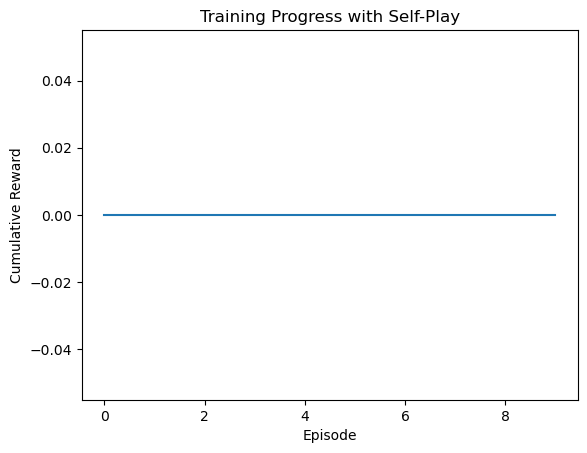

In [ ]:
import random

# Opponent storage
opponent_policies = []

# Step 1: Set up the environment
env = boxing_v2.env(render_mode="rgb_array")
env.reset(seed=42)
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)  # Resize frames to 84x84
env = dtype_v0(env, dtype="float32")  # Convert observations to float32
env = normalize_obs_v0(env, env_min=0, env_max=1)  # Normalize pixel values

parallel_env = aec_to_parallel(env)  # Convert to parallel format

# Step 2: Initialize PPO and RolloutBuffer
obs_shape = (1, 84, 84)  # Single frame (no stacking)
action_space = env.action_space("first_0")  # Example action space for an agent
ppo = PPO(obs_shape, action_space)

# Load pre-trained models if necessary
# ppo.load_value_network(value_model_path)  # load value network
# ppo.load_policy_network(policy_model_path) # load policy network

# Initialize the buffer
buffer = RolloutBuffer()

# Step 3: Training Loop
num_episodes = 50
max_steps_per_episode = 5000  # Maximum steps to prevent infinite loops
self_play_checkpoint_interval = 2  # Save the policy every N episodes for self-play
# Initialize reward tracking
cumulative_rewards = []

for episode in range(num_episodes):
    # Reset the environment
    observations = parallel_env.reset()

    # Extract nested observations (first element of the tuple)
    if isinstance(observations, tuple) and len(observations) > 0:
        agent_observations = observations[0]
    else:
        raise ValueError(f"Unexpected observation structure: {type(observations)}")

    # Initialize done flags for each agent
    done = {agent: False for agent in agent_observations.keys()}
    step = 0
    episode_reward = defaultdict(int)  # Track total reward for the episode

    # Choose an opponent policy for this episode
    if opponent_policies and random.random() < 0.5:
        opponent_policy = random.choice(opponent_policies)
    else:
        opponent_policy = None  # Use random actions if no opponent policy exists

    while not all(done.values()) and step < max_steps_per_episode:
        actions = {}
        log_probs = {}

        # Process observations for each agent
        for agent, obs in agent_observations.items():
            # Convert observations to grayscale if needed
            if obs.shape[-1] == 3:  # If RGB format
                obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels

            # Prepare tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

            # Decide the policy for each agent
            if agent == "first_0":
                # Use the current PPO policy for the first agent
                action_probs = ppo.policy.forward_policy(obs_tensor)
            else:
                # Use the opponent policy or random actions for the second agent
                if opponent_policy:
                    with torch.no_grad():
                        action_probs = opponent_policy(obs_tensor)
                else:
                    action_probs = torch.ones(action_space.n) / action_space.n  # Uniform random actions

            action = torch.multinomial(action_probs, 1).item()  # Sample action
            log_probs[agent] = torch.log(action_probs.squeeze(0)[action])  # Log probability
            actions[agent] = action  # Store action

        # Step the environment
        step_output = parallel_env.step(actions)

        if len(step_output) == 5:  # Handle truncations
            next_observations, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_observations, rewards, dones, infos = step_output

        # Extract nested observations for next step
        if isinstance(next_observations, dict):
            agent_observations = next_observations  # Observations are already in dictionary format
        else:
            raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")

        for agent, reward in rewards.items():
            episode_reward[agent] += reward
        
        # Store data in the buffer for each agent
        for agent, obs in agent_observations.items():
            buffer.store(obs, actions[agent], log_probs[agent].item(), rewards[agent], dones[agent])

        # Update done flags
        done = dones
        step += 1

    # Append episode reward
    cumulative_rewards.append(episode_reward)

    # Compute Returns and Advantages
    print(f"Episode {episode + 1}: Episode Reward = {episode_reward}")
    buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

    # Update PPO
    print(f"Episode {episode + 1}: Updating PPO model...")
    policy_losses, value_losses, total_losses = ppo.update(buffer)

    # Save the current policy for self-play periodically
    if (episode + 1) % self_play_checkpoint_interval == 0:
        saved_policy = PPOAgent(obs_shape, action_space)
        saved_policy.load_state_dict(ppo.policy.state_dict())
        opponent_policies.append(saved_policy)
        print(f"Checkpoint: Saved policy for self-play after Episode {episode + 1}")

    # Clear buffer for the next episode
    buffer.clear()

    # Log progress
    print(f"Episode {episode + 1}/{num_episodes} completed.")

# Plot cumulative rewards
plt.plot([sum(reward.values()) for reward in cumulative_rewards])
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Progress with Self-Play')
plt.show()


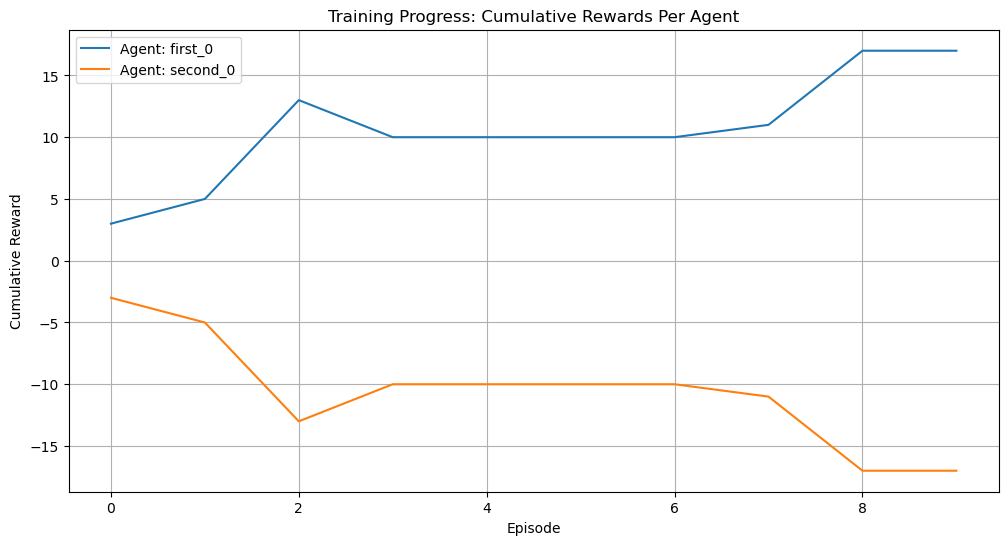

In [14]:
# Extract rewards for each agent
agent_rewards = {}
for episode_rewards in cumulative_rewards:
    for agent, reward in episode_rewards.items():
        if agent not in agent_rewards:
            agent_rewards[agent] = []
        agent_rewards[agent].append(reward)

# Plot cumulative rewards for each agent
plt.figure(figsize=(12, 6))
for agent, rewards in agent_rewards.items():
    cumulative_sum = np.cumsum(rewards)
    plt.plot(cumulative_sum, label=f"Agent: {agent}")

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Progress: Cumulative Rewards Per Agent')
plt.legend()
plt.grid(True)
plt.show()


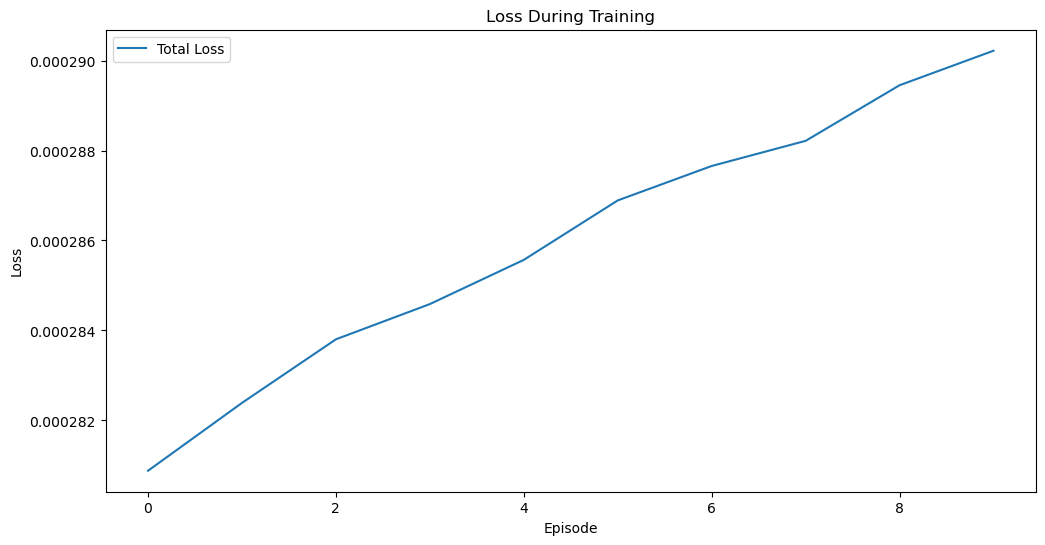

In [18]:
# Plot the losses
plt.figure(figsize=(12, 6))
# plt.plot(policy_losses, label='Policy Loss')
# plt.plot(value_losses, label='Value Loss')
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

In [20]:

# Save the trained PPO models
torch.save(ppo.policy.state_dict(), policy_model_path)
torch.save(ppo.policy.value_net.state_dict(), value_model_path)

print(f"Trained PPO models saved:")
print(f"Policy model: {policy_model_path}")
print(f"Value model: {value_model_path}")

Trained PPO models saved:
Policy model: ppo_trained_models_Dec_11/ppo_policy_model.pth
Value model: ppo_trained_models_Dec_11/ppo_value_model.pth


In [ ]:
# for agent, reward in rewards.items():
#         if reward != 0:
#             print(f"step: {step}, Agent: {agent}, Reward: {reward}")
#         cumulative_rewards[agent] += reward

In [ ]:
env.reset()

actions = {agent: env.action_space(agent).sample() for agent in env.agents}
print(f"Sampled Actions: {actions}")


Sampled Actions: {'first_0': 1, 'second_0': 5}


In [ ]:
for agent in env.agents:
    action = env.action_space(agent).sample()
    print(f"Agent: {agent}, Sampled Action: {action}")


Agent: first_0, Sampled Action: 6
Agent: second_0, Sampled Action: 15


In [ ]:
print(dir(env))  # Check available attributes and methods
print(env.reset.__doc__)  # Print the docstring of the reset method if available


['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_accumulate_rewards', '_check_wrapper_params', '_clear_rewards', '_deads_step_first', '_has_rendered', '_has_reset', '_has_updated', '_is_protocol', '_modify_action', '_modify_observation', '_modify_spaces', '_update_step', '_was_dead_step', 'action_space', 'agent_iter', 'change_obs_space_fn', 'change_observation_fn', 'close', 'env', 'last', 'max_num_agents', 'num_agents', 'observation_space', 'observe', 'render', 'reset', 'state', 'step', 'unwrapped']
None


step: 1895, Agent: first_0, Reward: -1
step: 1895, Agent: second_0, Reward: 1
step: 3102, Agent: first_0, Reward: 2
step: 3102, Agent: second_0, Reward: -2
step: 3281, Agent: first_0, Reward: -1
step: 3281, Agent: second_0, Reward: 1
step: 3993, Agent: first_0, Reward: 1
step: 3993, Agent: second_0, Reward: -1
step: 5302, Agent: first_0, Reward: 1
step: 5302, Agent: second_0, Reward: -1
step: 5763, Agent: first_0, Reward: 1
step: 5763, Agent: second_0, Reward: -1
Cumulative Rewards: defaultdict(<class 'int'>, {'first_0': 3, 'second_0': -3})


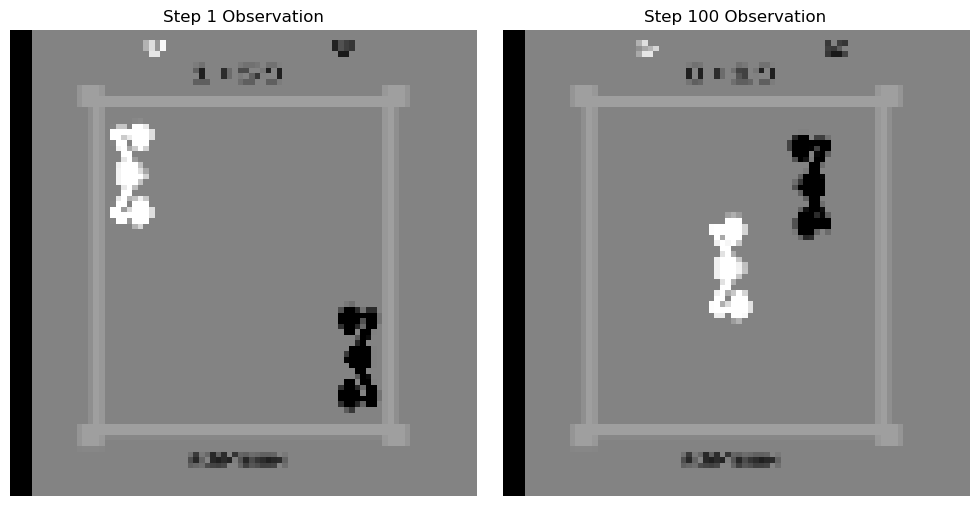

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reset the environment
observations = parallel_env.reset()

# Initialize a variable to store observations
step_1_observation = None
step_100_observation = None
cumulative_rewards = defaultdict(int)

for step in range(8000):
    # Sample random actions for all agents
    actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.agents}

    # Step the environment
    step_output = parallel_env.step(actions)

    if len(step_output) == 5:  # Handle truncations
        next_observations, rewards, dones, truncations, infos = step_output
        dones = {agent: dones[agent] or truncations[agent] for agent in dones}
    else:
        next_observations, rewards, dones, infos = step_output

    
    # Store the first and 100th observations
    if step == 0:
        step_1_observation = next_observations.copy()
    if step == 5999:
        step_100_observation = next_observations.copy()

    for agent, reward in rewards.items():
        if reward != 0:
            print(f"step: {step}, Agent: {agent}, Reward: {reward}")
        cumulative_rewards[agent] += reward
    
    # Break if the environment is done
    if all(dones.values()):
        break


print(f"Cumulative Rewards: {cumulative_rewards}")

# Visualize the observations for the first and 100th steps
agent = list(next_observations.keys())[0]  # Pick the first agent for visualization

# Convert the observations to grayscale if they are in RGB format
def preprocess_observation(obs):
    if len(obs.shape) == 3 and obs.shape[-1] == 3:  # RGB format
        obs = np.mean(obs, axis=-1)  # Convert to grayscale
    return obs

step_1_frame = preprocess_observation(step_1_observation[agent])
step_100_frame = preprocess_observation(step_100_observation[agent])

# Plot the frames
plt.figure(figsize=(10, 5))

# Step 1 observation
plt.subplot(1, 2, 1)
plt.imshow(step_1_frame, cmap='gray')
plt.title("Step 1 Observation")
plt.axis('off')

# Step 100 observation
plt.subplot(1, 2, 2)
plt.imshow(step_100_frame, cmap='gray')
plt.title("Step 100 Observation")
plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# for agent, obs in next_observations.items():
#     plt.imshow(obs)  # Assuming observations are raw frames
#     plt.title(f"Agent: {agent}")
#     plt.show()

print(env.rewards.__doc__)  # Print the docstring of the rewards method if available



dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [ ]:
# # Step 1: Set up the environment
# env = boxing_v2.env(render_mode="rgb_array")
# env.reset(seed=42)
# env = frame_skip_v0(env, 4)  # Frame skipping
# env = pad_observations_v0(env)
# env = pad_action_space_v0(env)
# env = resize_v1(env, 84, 84)  # Resize frames to 84x84
# env = dtype_v0(env, dtype="float32")  # Convert observations to float32
# env = normalize_obs_v0(env, env_min=0, env_max=1)  # Normalize pixel values

# parallel_env = aec_to_parallel(env)  # Convert to parallel format

# # Step 2: Initialize PPO and RolloutBuffer
# obs_shape = (1, 84, 84)  # Single frame (no stacking)
# action_space = env.action_space("first_0")  # Example action space for an agent
# ppo = PPO(obs_shape, action_space)
# buffer = RolloutBuffer()

# # Step 3: Training Loop
# num_episodes = 5
# max_steps_per_episode = 3000  # Maximum steps to prevent infinite loops
# # Initialize reward tracking
# cumulative_rewards = []

# for episode in range(num_episodes):
#     # Reset the environment
#     observations = parallel_env.reset()

#     # Extract nested observations (first element of the tuple)
#     if isinstance(observations, tuple) and len(observations) > 0:
#         agent_observations = observations[0]
#     else:
#         raise ValueError(f"Unexpected observation structure: {type(observations)}")

#     # Initialize done flags for each agent
#     done = {agent: False for agent in parallel_env.agents} # updated for skipping***********************************************
#     step = 0
#     episode_reward = defaultdict(int)  # Track total reward for the episode

#     while not all(done.values()) and step < max_steps_per_episode:
#         actions = {}
#         log_probs = {}

#         # Process observations for each agent
#         for agent in parallel_env.agents:
#             # print(f"Agent: {agent}")
#             if done[agent]:
#                 # Provide a placeholder action for done agents
#                 actions[agent] = parallel_env.action_space(agent).sample()
#             else:
#                 obs = agent_observations[agent]
#                 if obs.shape[-1] == 3:  # If RGB format
#                     obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels
#                 obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
#                 action_probs = ppo.policy.forward_policy(obs_tensor)
#                 action = torch.multinomial(action_probs, 1).item()
#                 actions[agent] = action


#         # Step the environment
#         try:
#             step_output = parallel_env.step(actions)
#         except AssertionError as e:
#             # Handle any unexpected sequence errors
#             print(f"Assertion Error: {e}")
#             break

#         # Handle the step output
#         if len(step_output) == 5:  # Handle truncations
#             next_observations, rewards, dones, truncations, infos = step_output
#             dones = {agent: dones.get(agent, False) or truncations.get(agent, False) for agent in parallel_env.agents}
#         else:
#             next_observations, rewards, dones, infos = step_output

#         # Update done flags
#         done = {agent: dones.get(agent, False) for agent in parallel_env.agents}

#         # Ensure `agent_observations` and other dictionaries are in sync
#         if isinstance(next_observations, dict):
#             agent_observations = {agent: next_observations.get(agent, None) for agent in parallel_env.agents}
#         else:
#             raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")

#         # Update rewards and store observations in the buffer
#         for agent in parallel_env.agents:
#             if not done.get(agent, False):
#                 obs = agent_observations.get(agent)
#                 if obs is None:
#                     print(f"Warning: Missing observation for agent {agent} at step {step}. Skipping.")
#                     continue
#                 buffer.store(
#                     obs,
#                     actions.get(agent, parallel_env.action_space(agent).sample()),
#                     log_probs.get(agent, 0.0),
#                     rewards.get(agent, 0.0),
#                     done.get(agent, False)
#                 )
#                 episode_reward[agent] += rewards.get(agent, 0.0)

#         # Ensure buffer is not empty
#         if len(buffer.observations) == 0:
#             print(f"Warning: Buffer is empty after step {step}.")

#         # Update done flags
#         done = {agent: dones[agent] or truncations[agent] for agent in parallel_env.agents}
#         step += 1

#     # Append episode reward
#     cumulative_rewards.append(episode_reward)

#     # Compute Returns and Advantages
#     print(f"Episode {episode + 1}: Episode Reward = {episode_reward}")
#     buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

#     # Update PPO
#     print(f"Episode {episode + 1}: Updating PPO model...")
#     ppo.update(buffer)

#     # Clear buffer for the next episode
#     buffer.clear()

#     # Log progress
#     print(f"Episode {episode + 1}/{num_episodes} completed.")


In [ ]:
# for episode in range(num_episodes):
#     # Reset the environment
#     observations = parallel_env.reset()

#     # Extract nested observations (first element of the tuple)
#     if isinstance(observations, tuple) and len(observations) > 0:
#         agent_observations = observations[0]
#     else:
#         raise ValueError(f"Unexpected observation structure: {type(observations)}")

#     # Initialize done flags for each agent
#     done = {agent: False for agent in agent_observations.keys()}
#     step = 0

#     while not all(done.values()) and step < max_steps_per_episode:
#         actions = {}
#         log_probs = {}

#         # Process observations for each agent
#         for agent, obs in agent_observations.items():
#             # Convert observations to grayscale if needed
#             if obs.shape[-1] == 3:  # If RGB format
#                 obs = obs.mean(axis=-1)  # Convert to grayscale by averaging RGB channels

#             # Prepare tensor with correct dimensions
#             obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

#             # Get action probabilities
#             action_probs = ppo.policy.forward_policy(obs_tensor)
#             action = torch.multinomial(action_probs, 1).item()  # Sample action
#             log_probs[agent] = torch.log(action_probs.squeeze(0)[action])  # Log probability
#             actions[agent] = action  # Store action

#         # Step the environment
#         step_output = parallel_env.step(actions)

#         if len(step_output) == 5:  # Handle truncations
#             next_observations, rewards, dones, truncations, infos = step_output
#             dones = {agent: dones[agent] or truncations[agent] for agent in dones}
#         else:
#             next_observations, rewards, dones, infos = step_output

#         # Extract nested observations for next step
#         if isinstance(next_observations, dict):
#             agent_observations = next_observations  # Observations are already in dictionary format
#         else:
#             raise ValueError(f"Unexpected observation structure after step: {type(next_observations)}")


#         # Store data in the buffer for each agent
#         for agent, obs in agent_observations.items():
#             buffer.store(obs, actions[agent], log_probs[agent].item(), rewards[agent], dones[agent])

#         # Update done flags
#         done = dones
#         step += 1

#     # Compute Returns and Advantages
#     print(f"Episode {episode + 1}: Computing returns and advantages...")
#     buffer.compute_returns_and_advantages(ppo.policy, ppo.gamma, ppo.gae_lambda)

#     # Update PPO
#     print(f"Episode {episode + 1}: Updating PPO model...")
#     ppo.update(buffer)

#     # Clear buffer for the next episode
#     buffer.clear()

#     # Log progress
#     print(f"Episode {episode + 1}/{num_episodes} completed.")